# CS 533 Assignment 3
## Introduction
The key objective for this assignment is to figure out the correlation of health outcomes with the community's poverty level. The basic outlines of this assignment are:
* Getting data from multiple sources
* Integration those data into one to perform the required analysis
* Use them to figure out the correlation

We are going to operationalize these as follows:

* Poverty rate: fraction of family households underneath the poverty line in 2014
* Health outcomes:
  * Mortality rates from infectious diseases in 2014
  * Infant mortality rate in 2014
* Unit of analysis: state


## Environment Setup
We will be using **pandas** and **numpy** for data processing and manipulation, **census** to provide access to Census API and fetch required data, **us** to get codes of necessary US states, and **seaborn** and **matplotlib** to visualize distributions and results. The **census** package will require an API key. [Request one here](https://api.census.gov/data/key_signup.html)

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from census import Census

In [5]:
c = Census("dc66950e8038b85d55fb6f692d5e69e38df8dee2")

## Data
We’re going to get data from 3 sources. FIPS codes will be used to link these data sets.
### 1. Income -US Census
We will get _income data_ from the [US Census Bureau](https://www.census.gov/en.html). The US Census Bureau provides [API Interface](https://www.census.gov/data/developers.html) interfaced from the Census package.

In [6]:
state_pop = pd.DataFrame.from_records(c.acs5.state(("NAME", "B05010_001E", "B05010_002E"), "*", year=2014))
state_pop.head()


,NAME,B05010_001E,B05010_002E,state
0,Alabama,1048560.0,281052.0,01
1,Alaska,179242.0,23963.0,02
2,Arizona,1532525.0,385737.0,04
3,Arkansas,663036.0,179070.0,05
4,California,8778017.0,1945049.0,06


In [7]:
state_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NAME         52 non-null     object 
 1   B05010_001E  52 non-null     float64
 2   B05010_002E  52 non-null     float64
 3   state        52 non-null     object 
dtypes: float64(2), object(2)
memory usage: 1.8+ KB


### 2. Infectious Diseases — GHDx
We will obtain infectious disease mortality rates from the [Global Health Data Exchange](http://ghdx.healthdata.org/record/ihme-data/united-states-infectious-disease-mortality-rates-county-1980-2014). These files contain county- and state-level mortality data from the U.S. from 1980 to 2014.

In [8]:
diseases_sheets = pd.read_excel("IHME_USA_COUNTY_INFECT_DIS_MORT_1980_2014_NATIONAL_Y2018M03D27.XLSX", sheet_name=None, header=1, skipfooter=2)
diseases_sheets.keys()

dict_keys(['Tuberculosis', 'HIV AIDS', 'Diarrheal diseases', 'Lower respiratory infections', 'Meningitis', 'Hepatitis'])

### 3. Infant Mortality — CDC
The Centers for Disease Control and Prevention provide a table of [infant mortality data by state](https://www.cdc.gov/nchs/pressroom/sosmap/infant_mortality_rates/infant_mortality.htm).

In [9]:
infant_mortality_rate_df = pd.read_csv("infant_mortality_rate_by_states.csv")
infant_mortality_rate_df.head()

,YEAR,STATE,RATE,DEATHS,URL
0,2019,AL,7.89,449,/nchs/pressroom/states/alabama/al.htm
1,2019,AK,4.81,48,/nchs/pressroom/states/alaska/ak.htm
2,2019,AZ,5.24,429,/nchs/pressroom/states/arizona/az.htm
3,2019,AR,6.9,251,/nchs/pressroom/states/arkansas/ar.htm
4,2019,CA,4.06,1879,/nchs/pressroom/states/california/ca.htm


In [10]:
infant_mortality_rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   YEAR    350 non-null    int64 
 1   STATE   350 non-null    object
 2   RATE    350 non-null    object
 3   DEATHS  350 non-null    int64 
 4   URL     350 non-null    object
dtypes: int64(2), object(3)
memory usage: 13.8+ KB


### 4. FIPS Codes
A [FIPS](https://en.wikipedia.org/wiki/FIPS_county_code) code is a numeric code that identifies a U.S. state or county. This FIPS code will be used to join all the data mentioned above. 

In [11]:
state_codes = pd.read_table("state.txt", sep="|")
state_codes.set_index("STUSAB", inplace=True)
state_codes.head()

,STATE,STATE_NAME,STATENS
STUSAB,,,
AL,1,Alabama,1779775
AK,2,Alaska,1785533
AZ,4,Arizona,1779777
AR,5,Arkansas,68085
CA,6,California,1779778


In [12]:
state_codes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57 entries, AL to VI
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   STATE       57 non-null     int64 
 1   STATE_NAME  57 non-null     object
 2   STATENS     57 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.8+ KB


## Analysis

We are going to see if the poverty rate is related with health outcomes.

#### Note: Function to calculate bootstrapped correlation

In [13]:
def boostraped_correlation(dataframe, column1, column2):
    NBOOT = 10000
    boot_corrs = np.empty(NBOOT)
    for i in range(NBOOT):
        sample = dataframe.sample(n=len(dataframe), replace=True)
        boot_corrs[i] = sample[column1].corr(sample[column2])
    return boot_corrs, np.quantile(boot_corrs, [0.025, 0.975])

### 1. Distribution of states poverty rate

In [14]:
state_pop.rename(columns={
    "B05010_001E": "total",
    "B05010_002E": "under_poverty_line"
}, inplace=True)
state_pop["rate_under_poverty_line"] = state_pop["under_poverty_line"]/state_pop["total"]
state_pop = state_pop.astype({"state": "i4"})
state_pop.set_index("state", inplace=True)

In [15]:
state_pop["rate_under_poverty_line"].describe()

count    52.000000
mean      0.207473
std       0.070696
min       0.110946
25%       0.153843
50%       0.196620
75%       0.247620
max       0.566731
Name: rate_under_poverty_line, dtype: float64

The median is slightly lower that the mean value. This we might see a slightly right skewed distribution.

Text(0.5, 1.0, 'Distribution of Poverty Rate')

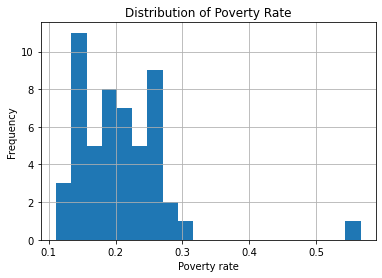

In [16]:
state_pop["rate_under_poverty_line"].hist(bins=20)
plt.xlabel("Poverty rate")
plt.ylabel("Frequency")
plt.title("Distribution of Poverty Rate")

We see that the distribution is not that skewed. Rather we see an outlier that pulled mean toward it causing it to be a little bit higher.

Text(0, 0.5, 'States')

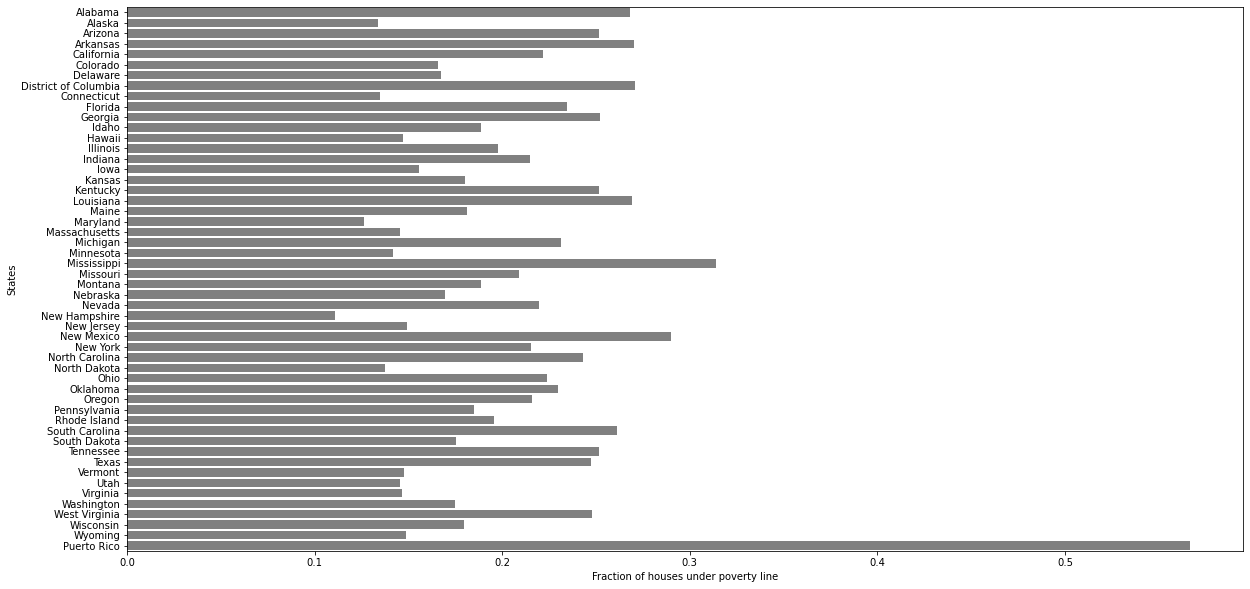

In [17]:
plt.figure(figsize=(20,10))
sns.barplot(x="rate_under_poverty_line", y="NAME", data=state_pop, color="gray")
plt.xlabel("Fraction of houses under poverty line")
plt.ylabel("States")

We can see that Purto Rico has a higher poverty rate than others.

### 2. Relationship between Poverty rates and Mortality rates

#### Scatter Plots and Correlation Coefficients

In [18]:
df_meningitis = diseases_sheets["Meningitis"]
df_meningitis = df_meningitis[(df_meningitis["FIPS"] > 0) &(df_meningitis["FIPS"] < 100 )]
df_meningitis = df_meningitis.rename(columns={
    "Mortality Rate, 2014*": "Mortality"
})
df_meningitis["Mortality"].replace(to_replace=r"\s*\(.+\)",value= "", regex=True, inplace=True)
df_meningitis = df_meningitis.astype({"FIPS": "i4", "Mortality": "f8"})
df_meningitis = df_meningitis[["Location", "FIPS", "Mortality"]]
df_meningitis.set_index("FIPS", inplace=True)
df_meningitis = df_meningitis.join(state_pop)

In [19]:
df_meningitis["Mortality"].describe()

count    51.000000
mean      0.415490
std       0.091985
min       0.270000
25%       0.345000
50%       0.400000
75%       0.470000
max       0.660000
Name: Mortality, dtype: float64

The mean is a bit higher than the median causing the distribution to be slightly right skewed.

Text(0.5, 1.0, 'Correlation between Meningitis Mortality rate and Poverty rate')

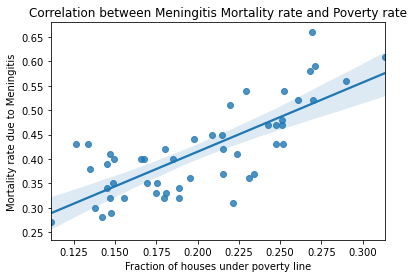

In [20]:
sns.regplot(x="rate_under_poverty_line", y="Mortality", data=df_meningitis)
plt.xlabel("Fraction of houses under poverty line")
plt.ylabel("Mortality rate due to Meningitis")
plt.title("Correlation between Meningitis Mortality rate and Poverty rate")

From the scatter plot and trend line, we can see that there is a positive correlation between Mortality rate due to Meningitis and the Poverty rate.

In [21]:
df_meningitis["Mortality"].corr(df_meningitis["rate_under_poverty_line"])

0.7666266512876152

The correlation coefficient is nearly equal to 0.77 justifying the graph. 

In [22]:
df_diarrheal = diseases_sheets["Diarrheal diseases"]
df_diarrheal = df_diarrheal[(df_diarrheal["FIPS"] > 0) &(df_diarrheal["FIPS"] < 100 )]
df_diarrheal = df_diarrheal.rename(columns={
    "Mortality Rate, 2014*": "Mortality"
})
df_diarrheal["Mortality"].replace(to_replace=r"\s*\(.+\)",value= "", regex=True, inplace=True)
df_diarrheal = df_diarrheal.astype({"FIPS": "i4", "Mortality": "f8"})
df_diarrheal = df_diarrheal[["Location", "FIPS", "Mortality"]]
df_diarrheal.set_index("FIPS", inplace=True)
df_diarrheal = df_diarrheal.join(state_pop)

In [23]:
df_diarrheal["Mortality"].describe()

count    51.000000
mean      2.356667
std       0.714162
min       0.490000
25%       1.810000
50%       2.310000
75%       2.850000
max       4.080000
Name: Mortality, dtype: float64

The mean is a bit higher than the median causing the distribution to be slightly right skewed.

Text(0.5, 1.0, 'Correlation between Diarrheal Mortality rate and Poverty rate')

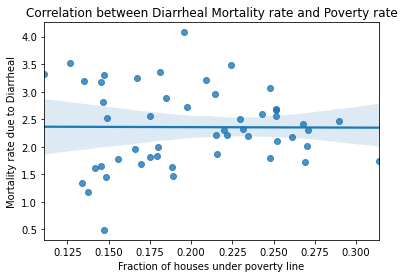

In [24]:
sns.regplot(x="rate_under_poverty_line", y="Mortality", data=df_diarrheal)
plt.xlabel("Fraction of houses under poverty line")
plt.ylabel("Mortality rate due to Diarrheal")
plt.title("Correlation between Diarrheal Mortality rate and Poverty rate")

From the scatter plot and trend line, we can see that there is almost no correlation between Mortality rate due to Diarrheal Disease and the Poverty rate.

In [25]:
df_diarrheal["Mortality"].corr(df_diarrheal["rate_under_poverty_line"])

-0.005990448531004337

The correlation coefficient is nearly equal to 0 justifying the graph. 

#### Bootstrapped Correlation Coefficients 

In [26]:
sample_dist_meningitis_mortality, ci95_meningitis_mortality = boostraped_correlation(df_meningitis, "Mortality", "rate_under_poverty_line")
ci95_meningitis_mortality

array([0.62924497, 0.8649942 ])

The Bootstrapped Confidence Interval for Correlation Coefficients is 0.63 to 0.86.

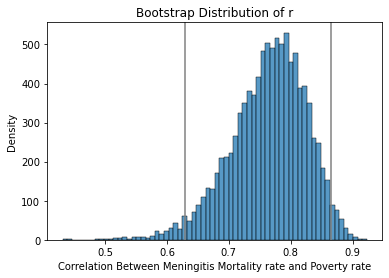

In [27]:
sns.histplot(sample_dist_meningitis_mortality)
lb, ub = ci95_meningitis_mortality
plt.axvline(lb, color="gray")
plt.axvline(ub, color="gray")
plt.title("Bootstrap Distribution of r")
plt.ylabel("Density")
plt.xlabel("Correlation Between Meningitis Mortality rate and Poverty rate")
plt.show()

The graphs shows the Bootstrapped Sample Distribution of Correlation coefficient. 

In [28]:
sample_dist_diarrheal_mortality, ci95_diarrheal_mortality = boostraped_correlation(df_diarrheal, "Mortality", "rate_under_poverty_line")
ci95_diarrheal_mortality

array([-0.28790998,  0.28135356])

The Bootstrapped Confidence Interval for Correlation Coefficients is -0.28 to 0.27.

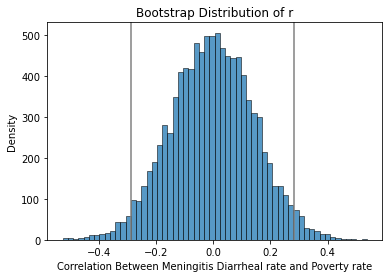

In [29]:
sns.histplot(sample_dist_diarrheal_mortality)
lb, ub = ci95_diarrheal_mortality
plt.axvline(lb, color="gray")
plt.axvline(ub, color="gray")
plt.title("Bootstrap Distribution of r")
plt.ylabel("Density")
plt.xlabel("Correlation Between Meningitis Diarrheal rate and Poverty rate")
plt.show()

The graphs shows the Bootstrapped Sample Distribution of Correlation coefficient. 

### 3. Relationship between Poverty rates and Infant Mortality rates


#### Scatter Plots and Correlation Coefficients

In [30]:
infant_mortality_rate_df = infant_mortality_rate_df[infant_mortality_rate_df["YEAR"] == 2014]
infant_mortality_rate_df = pd.merge(left=infant_mortality_rate_df, right=state_codes, left_on="STATE", right_index=True)
infant_mortality_rate_df = infant_mortality_rate_df[["STATE", "RATE", "DEATHS", "STATE_y"]]
infant_mortality_rate_df.rename(columns={
    "STATE_y": "STATE_CODE"
}, inplace=True)
infant_mortality_rate_df = infant_mortality_rate_df.astype({
    "RATE": "f8"
})
infant_mortality_rate_df.set_index("STATE_CODE", inplace=True)
infant_mortality_rate_df = infant_mortality_rate_df.join(state_pop)

In [38]:
infant_mortality_rate_df["RATE"].describe()

count    50.000000
mean      5.935000
std       1.148879
min       4.320000
25%       4.935000
50%       5.870000
75%       6.722500
max       8.670000
Name: RATE, dtype: float64

The mean is a bit higher than the median causing the distribution to be slightly right skewed.

Text(0.5, 1.0, 'Correlation between Infant Mortality rate and Poverty rate')

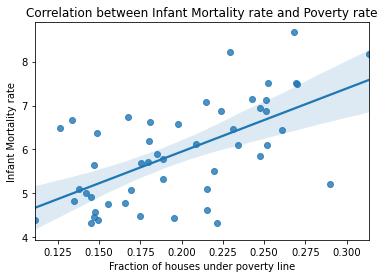

In [32]:
sns.regplot(x="rate_under_poverty_line", y="RATE", data=infant_mortality_rate_df)
plt.xlabel("Fraction of houses under poverty line")
plt.ylabel("Infant Mortality rate")
plt.title("Correlation between Infant Mortality rate and Poverty rate")

From the scatter plot and trend line, we can see that there is a positive correlation between Infant Mortality rate and the Poverty rate.

In [33]:
infant_mortality_rate_df["RATE"].corr(infant_mortality_rate_df["rate_under_poverty_line"])

0.6154666056611093

The correlation coefficient is nearly equal to 0.62 justifying the graph. 

#### Bootstrapped Correlation Coefficients 

In [34]:
sample_dist_infant_mortality, ci95_infant_mortality = boostraped_correlation(infant_mortality_rate_df, "RATE", "rate_under_poverty_line")
ci95_infant_mortality

array([0.3937046 , 0.78650367])

The Bootstrapped Confidence Interval for Correlation Coefficients is 0.39 to 0.79.

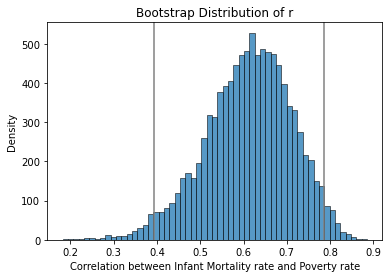

In [35]:
sns.histplot(sample_dist_infant_mortality)
lb, ub = ci95_infant_mortality
plt.axvline(lb, color="gray")
plt.axvline(ub, color="gray")
plt.title("Bootstrap Distribution of r")
plt.ylabel("Density")
plt.xlabel("Correlation between Infant Mortality rate and Poverty rate")
plt.show()

The graphs shows the Bootstrapped Sample Distribution of Correlation coefficient. 

## Summary

The primary purpose of this assignment was to learn about collecting data from various data sources, manipulating data and integrating them into a required format in order to perform required analysis. This assignment was about correlating various data set attributes and study relationship between the variables i.e. How poverty rate is correlated to health outcomes such as Mortality rate from Infectious Disease and Infant Mortality rate.

The first thing we learned from this assignment is about preparing data for the analysis. The purpose of this assignment was to find the relation of poverty rate with various mortality rates. The data needed for this analysis was a report containing Income data and death rates due to multiple diseases and conditions.   We used the US census data to get the Income report. Similarly, we used Global Health Exchange data for Mortality rate due to diseases and the Center for Disease Control for Infant Mortality rate. We also learned about linking various data set to widen the variable set. Some data sets can be linked readily, and some need to be processed to connect with a shared variable. One of the learnings of this assignment was the relation of poverty rate with the mortality rate and how correlation coefficient can help. We also learned to bootstrap the confidence interval for the correlation coefficient. Other than the correlation coefficient, a Scatter plot seems to be very useful for visualizing the relationship. 

The advantage of using correlation is to uncover the relationship that may not have been found. But it cannot provide a conclusive result that why the connection exists and which variable is responsible for influencing the other.  All we can do with the information is study the relationships between phenomena to see how each one affects the other. Knowing that one change can create additional alternations can be beneficial when looking for unique outcomes. Still, it fails to answer the question of “why” that is sometimes necessary for research. Correlation doesn’t mean causation.

For this assignment, we are using data from three different sources. The analysis requires us to link these data to study the relationship.  It required some pre-processing as the common variable that links the table was not the same.  We used an extra FIPS code table to link Infant mortality rate data to that of Census data. Also, for the health data, the value for mortality rate was not in the standard format. It required some data parsing and manipulations. As we look into the data, we find some of the missing values of Mortality rates for different disease which gets dropped while joining with census data. Data we used were collected via different sources and some of them were inconsistent that resulted in dropping of some values.